In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time # used to evaluate time performances
import os
import random
from tqdm import tqdm, tnrange

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

# Functions

Note: I tried also cross validation, but the validation loss on the K folds was basically the same for a given set of Hyper-Parameters (HP), thus I decided to use a single training-validation split with proportions 80-20.

In [3]:
def GridSearch(model, train_loader, val_loader, params_comb, checkpoint=True, 
               save_dir='checkpoint', parent_dir='.', verbose=False):
    """
    Parameters
    ----------
    model      : class of the predictor
        Must be instantiated as model(**params)
    train_loader: torch DataLoader
        Loads the training set
    val_loader: torch DataLoader
        Loads the validation set
    params_comb: list of dictionaries {'model_HP':value}
        All combinations of hyper-parameters to be evaluated
    checkpoint: bool
        If True, saves dictionary and parameters after each
        parameter evaluated
    save_dir: str
        Path to the directory where to save checkpoints
    
    Returns
    -------
    scoring    : list of all the losses 
    epochs: list of the number of epochs of training for each 
                 configuration of HPs
    """
    import time
    scoring = []
    deviations = []
    train_epochs = []
    combinations = len(params_comb)
    init_time = time.time()
    for i in range(combinations):
        start = time.time()
        params = params_comb[i]
        train_loss_log, val_loss_log = train_torchNN(model, train_loader, val_loader, train_log=True,
                                                 verbose=verbose, debug=False, **params) 
        scoring.append(val_loss_log[-1])
        train_epochs.append(len(val_loss_log))
        
        print('\nParameters configuration %d out of %d'%(i+1,len(params_comb)))
        print_HP_score(params,scoring[-1])
        finish = time.time()
        print('Time for evaluation: %.1f s'%(finish-start))
        time_to_finish = (combinations-i-1)*(finish-init_time)/(i+1)
        
        if time_to_finish > 3600:
            print('Estimated time to finish : %.2f h'%(time_to_finish/3600), '\n')
        elif time_to_finish < 3600 and time_to_finish > 60:
            print('Estimated time to finish : %.2f min'%(time_to_finish/60), '\n')
        else:
            print('Estimated time to finish : %.2f s'%(time_to_finish), '\n')
            
        if checkpoint:
            if save_dir not in os.listdir(parent_dir):
                print("Creating directory "+save_dir)
                os.mkdir(parent_dir+'/'+save_dir)
            
            scores_filename = 'scores.npy'
            dict_filename = 'dict.npy'
            scores_path = parent_dir+'/'+save_dir+'/'+scores_filename
            dict_path = parent_dir+'/'+save_dir+'/'+dict_filename
            
            # load from save_dir if file is present
            if scores_filename not in os.listdir(parent_dir+'/'+save_dir):
                print('Creating new checkpoint...')
                checkpoint_scores = []
                checkpoint_dict = []
            else:
                print('Loading checkpoint...')
                checkpoint_scores = list(np.load(scores_path))
                checkpoint_dict = list(np.load(dict_path, allow_pickle=True))
                print('Total number of configurations evaluated: ', len(checkpoint_scores))
            
            # append update
            checkpoint_scores.append(val_loss_log[-1])
            checkpoint_dict.append(params_comb[i])
            
            # save to save_dir ([:-4] is to remove .npy from strings)
            print('Saving parameters and losses...')
            np.save(scores_path[:-4], checkpoint_scores) 
            np.save(dict_path[:-4], checkpoint_dict)
            
    return scoring, train_epochs

In [4]:
def print_parameters(params):
    print("Parameters: ")
    print('='*75)
    for key in params:
        if (key == 'lr'):
            print(key, '\t \t', params[key])
        else:
            print(key, '\t', params[key])
    print('='*75)

def print_HP_score(params,score):
    print_parameters(params)
    print("Loss: %.4f "%(score))

In [5]:
#%% Define the network architecture
class Autoencoder(nn.Module):
    def __init__(self, encoded_space_dim, dropout=0.2):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout(dropout)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Dropout(dropout)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
### Testing function
def test_epoch(net, dataloader, loss_fn, optimizer):

    # select device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        batch_len = np.zeros(len(dataloader))
        batch_loss = np.zeros(len(dataloader))
        for i, sample_batch in enumerate(dataloader,0):
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            out = net(image_batch)
            
            # Evaluate global loss
            loss = loss_fn(out, image_batch)
            
            # save MSE loss and length of a batch
            batch_len[i] = len(sample_batch[0])
            batch_loss[i] = loss.item()
    
    # total MSE loss
    val_loss = (batch_loss*batch_len).sum()/batch_len.sum()
    return val_loss

In [7]:
def train_torchNN(model,  train_loader, val_loader, train_log=True, verbose=True, 
                  debug=False, return_model = False, **params):
    """
    Trains a Pytorch model.
    
    Parameters
    ----------
    model: Pytorch nn.Module class 
        Must have forward method
    train_loader: torch DataLoader
        Loads the training set
    val_loader: torch DataLoader
        Loads the validation set
    verbose: bool
        If True prints updates of the training 10 times for each epoch
    return_model: bool
        If True returns the trained instance of the model 
    **params: dictionary 
        Must contain all the parameters needed by the model, the optimizer and the loss
    
    Returns
    -------
    net (if return_model): Pytorch nn.Module class
        Trained instance of the model 
    train_loss_log (if train_log): list
        Training loss for each epoch
    val_loss_log (if train_log): list
        Validation loss for each epoch
    val_acc_log (if train_log): list
        Validation accuracy for each epoch
    
    """
    model_keys = ['encoded_space_dim','dropout'] # parameters of the model
    optim_keys = ['lr','weight_decay'] # parameters of the optimizer
    model_params = {}
    optim_params = {}
    # reads out the params dictionary and fills the model and optim dictionaries
    for k in params.keys():
        if k in model_keys:
            model_params[k] = params[k]
        elif k in optim_keys:
            optim_params[k] = params[k]
    n_epochs = params['n_epochs']

    # init method
    net = model(**model_params)
    # init optimizer
    optimizer = optim.Adamax(net.parameters(), **optim_params)
    # define mean square error loss 
    loss_fn = nn.MSELoss()
    
    # define contextual print functions activated by print flags
    verbose_print = print if verbose else lambda *a, **k: None
    verbose_print("Verbose: ", verbose)
    dprint = print if debug else lambda *a, **k: None
    dprint("Debug: ", debug)

    # If cuda is available set the device to GPU
    verbose_print("Using cuda: ", torch.cuda.is_available())
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    # Move all the network parameters to the selected device (if they are already on that device nothing happens)
    net.to(device)
    
    n_batches = len(train_loader)
    epoch_time = []
    #Time for printing
    training_start_time = time.time()
    # lists with the history of the training
    if (train_log == True):
        train_loss_log = []
        val_loss_log = []

    #Loop for n_epochs
    for epoch in range(n_epochs):

        running_loss = 0.0
        print_every = n_batches // 10 # frequency of printing
        start_time = time.time()
        total_train_loss = 0
        batches_done = 0
        net.train() # activate dropout
        for i, data in enumerate(train_loader, 0):
            batches_done += 1
            optimizer.zero_grad()
            # Extract data and move tensors to the selected device
            image_batch = data[0].to(device)
            # Forward pass
            output = net(image_batch)
            loss = loss_fn(output, image_batch)
            dprint('loss: ', loss.item())
            # Backward pass
            loss.backward()
            optimizer.step()

            if i == 10 and debug:
                with torch.no_grad():
                    out = net(image_batch).cpu()
                
                
                fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,5))
                ax[0].imshow(image_batch[0].cpu().squeeze().numpy(), cmap='gist_gray')
                ax[0].set_title("Original image")
                ax[1].imshow(out[0].squeeze().numpy(), cmap='gist_gray')
                ax[1].set_title("Reconstructed image")

            #Print statistics
            running_loss += loss.item() 
            total_train_loss += loss.item()
            #Print every 10th batch of an epoch
            if ((i+1) % (print_every) == 0) or (i == n_batches - 1):
                verbose_print('\r'+"Epoch {}, {:d}% \t Train loss: {:.4f} took: {:.2f}s ".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / batches_done,
                        time.time() - start_time), end=' ')
                
        epoch_time.append(time.time() - start_time)
        if (train_log == True):
            train_loss_log.append(total_train_loss/len(train_loader))
        
        
        #At the end of the epoch, do a pass on the validation set
        val_loss = test_epoch(net, dataloader=val_loader, loss_fn=loss_fn, optimizer=optimizer) 
        if (train_log == True):
            val_loss_log.append(val_loss)
            verbose_print("Val. loss: {:.4f}".format(val_loss ))

    verbose_print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    if train_log:
        if return_model:
            return net, train_loss_log, val_loss_log#, val_acc_log
        else:
            return train_loss_log, val_loss_log#, val_acc_log  #used during cross validation

## Import data and split them

In [8]:
#%% Define paths

data_root_dir = '../datasets'


#%% Create dataset

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

training_dataset = MNIST(data_root_dir, train=True,  download=False, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=False, transform=test_transform)

In [105]:
train_batch_size = 512
val_batch_size = 512
test_batch_size = 512

val_perc = 0.2
m = len(training_dataset)
train_len = int(m*(1-val_perc))

train_dataset = TensorDataset((training_dataset.data[:train_len]/255.).view(-1,1,28,28).float())
val_dataset = TensorDataset((training_dataset.data[train_len:]/255.).view(-1,1,28,28).float())

# create DataLoaders to load batches
train_loader = DataLoader(train_dataset, train_batch_size, shuffle=True, num_workers = 2, drop_last=True)
val_loader = DataLoader(val_dataset, val_batch_size,  num_workers = 2)
test_loader = DataLoader(test_dataset, test_batch_size, num_workers = 2)

## Single training

In [10]:
# example of parameters dictionary
net_dict = {'encoded_space_dim' : 4,
            'dropout' : 0.2,
            'lr' : 0.01,
            'n_epochs' : 1, #10
            'weight_decay' : 1e-5}

In [ ]:
results = train_torchNN(Autoencoder, train_loader, val_loader, train_log=True, verbose=True, 
                           return_model=True,  **net_dict)
net, train_loss_log, val_loss_log = results
torch.save(net.state_dict(), 'net_params.pth')

In [ ]:
epochs = np.arange(len(train_loss_log))+1
plt.plot(epochs, train_loss_log, label = 'train')
plt.plot(epochs, val_loss_log, label = 'validation')
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('MSE loss', fontsize=16)
plt.legend(fontsize=13)
plt.show()

### Sanity check

In [12]:
def show_results(net, test_dataset, n_samples=10):
    x = [test_dataset[i][0] for i in range(n_samples)]
    x = torch.cat(x).view(-1,1,28,28)
    with torch.no_grad():
        out = net(x)
    
    for i in range(n_samples):
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,5))
        ax[0].imshow(x[i].squeeze().numpy(), cmap='gist_gray')
        ax[0].set_title("Original image")
        ax[1].imshow(out[i].squeeze().numpy(), cmap='gist_gray')
        ax[1].set_title("Reconstructed image")

In [ ]:
net.to('cpu')
#net = Autoencoder(encoded_space_dim=2, dropout=0) # not trained
show_results(net, test_dataset, n_samples=10)

## Sampling parameters for random search

In [13]:
class prior_distr():
    def __init__(self, discrete, var_type, distribution, **kwargs):
        self.discrete = discrete
        self.type = var_type
        if discrete:
            if var_type == 'int':
                if distribution == 'exp':
                    self.distr = distribution
                    self.N_min = kwargs['N_min']
                    self.N_max = kwargs['N_max']
                    self.alpha = kwargs['alpha']
                    self.elements = np.arange(self.N_min,self.N_max+1)
                elif distribution == 'uniform':
                    self.distr = distribution
                    self.N_min = kwargs['N_min']
                    self.N_max = kwargs['N_max']
                    self.elements = np.arange(self.N_min,self.N_max+1)
                    self.probabilities = np.full(len(self.elements), 1/len(self.elements))
                elif distribution == 'custom':
                    self.distr = distribution
                    self.elements = kwargs['elements']
                    if (np.abs(kwargs['p'].sum()-1) < 1e-4):
                        self.probabilities = kwargs['p']
                    else:
                        raise Exception ('Total probability must be equal to 1.')
                else:
                    raise Exception('Variable \'distribution\' must be \'exp\', \'uniform\' or \'custom\'.')
            elif var_type == 'str':
                self.elements = kwargs['elements']
                self.distr = distribution
                if distribution == 'uniform':
                    self.probabilities = np.full(len(self.elements), 1/len(self.elements))
                elif distribution == 'custom':
                    if (np.abs(kwargs['p'].sum()-1) < 1e-4):
                        self.probabilities = kwargs['p']
                    else:
                        raise Exception ('Total probability must be equal to 1.')
                else:
                    raise Exception('Variable \'distribution\' must be \'uniform\' or \'custom\'.')
            else:
                raise Exception('Type must be \'int\' or \'str\'.')
        else:
            # continuous case
            if var_type == 'float':
                if distribution == 'uniform':
                    self.distr = distribution
                    self.x_min = kwargs['x_min']
                    self.x_max = kwargs['x_max']
                elif distribution == 'log':
                    self.distr = distribution
                    self.x_min = kwargs['x_min']
                    self.x_max = kwargs['x_max']
                else:
                    raise Exception('Distribution must be \'uniform\' or \'log\'.')
            else:
                raise Exception('Continuous type must be \'float\'.')
        
    def sample(self, n_samples):
        if self.discrete == True:
            def sample_from_discrete_distr(n_samples, p_cum):
                u = np.random.rand(n_samples)
                mask = np.tile(p_cum[:,np.newaxis], (1,len(u))) > u
                samples = self.elements[np.argmax(mask, axis=0)]
                return samples

            if (self.type == 'int') and (self.distr == 'exp'): # only case in which self.probabilities is not defined
                def exp_distr(n):
                    exp_of_Ns = np.exp(-self.alpha*self.elements)
                    norm_factor = exp_of_Ns.sum() # 1/(e^alpha - 1)
                    p_of_n = np.exp(-self.alpha*n)/norm_factor
                    return p_of_n
                #Ns = self.elements
                self.probabilities = exp_distr(self.elements) # compute prob of each element
            p_cum = np.cumsum(self.probabilities)
            return sample_from_discrete_distr(n_samples, p_cum)
        else:
            if self.distr == 'uniform':
                samples = np.random.rand(n_samples)*(self.x_max - self.x_min) - self.x_min
            else:
                u = np.random.rand(n_samples)*(np.log(self.x_max)-np.log(self.x_min)) + np.log(self.x_min)
                samples = np.exp(u)
            return samples

In [14]:
# spans different magnitude scales, use logaritmic distribution for invariance of scale
lr_P_dict = dict(discrete=False,
                var_type='float',
                distribution='log',
                x_min = 1e-3,
                x_max = 1e-1)

# weight_decay
penalty_P_dict = dict(discrete=False,
                    var_type='float',
                    distribution='log',
                    x_min = 1e-4,
                    x_max = 1e-2)

# acts on the number of neurons in a linear way, use uniform distribution
dropout_P_dict = dict(discrete=False,
                     var_type = 'float',
                     distribution='uniform',
                     x_min = 0,
                     x_max = 0.25)

# n_epochs should be of the order of 10, but I also want to try up to 50 
n_epochs_P_dict = dict(discrete=True,
                         var_type = 'int',
                         distribution='custom',
                         elements=np.array([10,20,30,40,50]),
                         p = np.array([0.25, 0.25, 0.20, 0.20, 0.10]))

In [15]:
P_dict = dict(lr=lr_P_dict, 
              weight_decay=penalty_P_dict, 
              dropout=dropout_P_dict,
              n_epochs=n_epochs_P_dict)

In [16]:
n_samples = 1 # just a demo

In [17]:
params = {}
for key in P_dict.keys():
    P = prior_distr(**P_dict[key])
    params[key] = P.sample(n_samples)

In [18]:
# now we make a list of dictionary instead of a dictionary of lists and we also add the last constant parameters
list_of_dict = []
for i in range(n_samples):
    d = {'encoded_space_dim' : 4}
    for key in params.keys():
        d[key] = params[key][i]
    list_of_dict.append(d)

In [19]:
print("Number of combinations: ", len(list_of_dict))

flag = True #set to True to see all combinations
if flag == True:
    for params in list_of_dict:
        print()
        print_parameters(params)

Number of combinations:  1

Parameters: 
encoded_space_dim 	 4
lr 	 	 0.002823805289074982
weight_decay 	 0.0013553847378807568
dropout 	 0.0671707806214899
n_epochs 	 40


## Note
The real training was done on Google Colab making use of the GPU given at disposal.

In [ ]:
%%time
scoring, _ = GridSearch(Autoencoder, train_loader, val_loader, list_of_dict, verbose=True)

# HP analysis

In [20]:
checkpoint_scores = np.load('checkpoint/scores.npy')
checkpoint_dict = list(np.load('checkpoint/dict.npy', allow_pickle=True))

In [23]:
n_configs = len(checkpoint_scores)
print('Number of configuration evaluated: ', n_configs)

Number of configuration evaluated:  174


### Best configuration

In [22]:
scoring = np.array(checkpoint_scores)
best = np.argmin(scoring)
print_HP_score(checkpoint_dict[best],scoring[best])

Parameters: 
encoded_space_dim 	 4
lr 	 	 0.01359510084742712
weight_decay 	 0.00010797152157531271
dropout 	 0.021559902776276146
n_epochs 	 40
Loss: 0.0320 


### Performance of different configurations

Look at dropout, learning rate, weight decay and number of epochs vs loss.

In [25]:
learning_rates = []
weights = []
dropouts = []
epochs = []
for i in range(n_configs):
    learning_rates.append(checkpoint_dict[i]['lr'])
    weights.append(checkpoint_dict[i]['weight_decay'])    
    dropouts.append(checkpoint_dict[i]['dropout'])
    epochs.append(checkpoint_dict[i]['n_epochs'])    
learning_rates = np.array(learning_rates)
weights = np.array(weights)
dropouts = np.array(dropouts)
epochs = np.array(epochs)

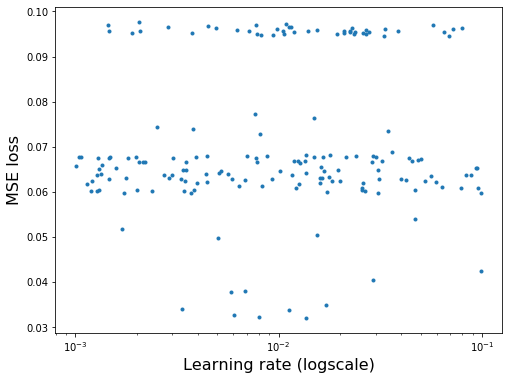

In [72]:
plt.figure(figsize=(8,6))
plt.plot(learning_rates, scoring, '.')
plt.xscale('log')
plt.xlabel('Learning rate (logscale)', fontsize=16)
plt.ylabel('MSE loss', fontsize=16)
plt.show()

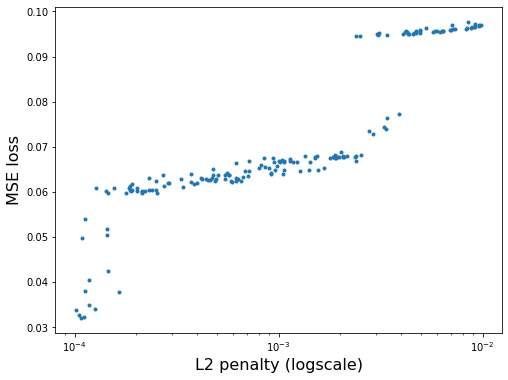

In [74]:
plt.figure(figsize=(8,6))
plt.plot(weights, scoring, '.')
plt.xscale('log')
plt.xlabel('L2 penalty (logscale)', fontsize=16)
plt.ylabel('MSE loss', fontsize=16)
plt.show()

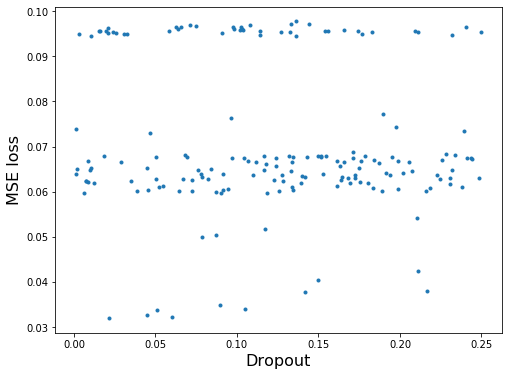

In [75]:
plt.figure(figsize=(8,6))
plt.plot(dropouts, scoring, '.')
plt.xlabel('Dropout', fontsize=16)
plt.ylabel('MSE loss', fontsize=16)
plt.show()

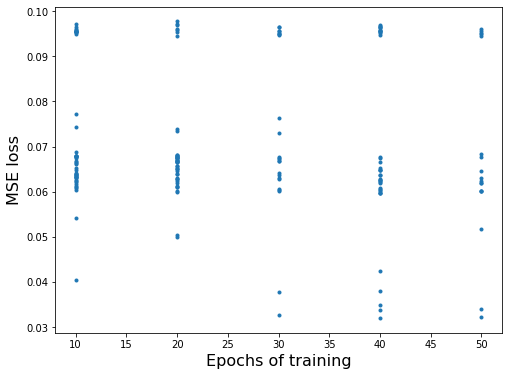

In [76]:
plt.figure(figsize=(8,6))
plt.plot(epochs, scoring, '.')
plt.xlabel('Epochs of training', fontsize=16)
plt.ylabel('MSE loss', fontsize=16)
plt.show()

As a general observation only the L2 penalty term seems to affect clearly the performance, with a monotonic increase in the loss as the penalty term increases. Therfore it's not a case that the best model has the almost the minimum penalty (around $10^{-4}$).

In [77]:
np.save('best_model_dict', checkpoint_dict[best])

# Compression-performance tradeoff in autoencoders

In [83]:
encoded_space_dims = [1,2,4,8,16]
best_model_dict = np.load('best_model_dict.npy', allow_pickle=True).item()

### Training on the uncorrupted training set
Input: uncorrupted <br>
Target: uncorrupted

In [ ]:
for encoded_space_dim in encoded_space_dims:
    best_model_dict['encoded_space_dim'] = encoded_space_dim
    results = train_torchNN(Autoencoder, train_loader, val_loader, train_log=True, verbose=True, 
                           return_model=True,  **net_dict)
    net, train_loss_log, val_loss_log = results
    torch.save(net.state_dict(), 'net_params_'+str(encoded_space_dim)+'.pth')

# Optional part: denoising autoencoders

### Training on the training set with gaussian noise
**Input:** added gaussian noise <br>
**Target:**  uncorrupted

**Note:** for simplicity I used a single intermediate noise intensity in training.

First of all I need to define a new Dataset class where the input is noisy but the output is not.

In [96]:
class NoisyDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        
        assert len(dataset1) == len(dataset2), "Datasets should have the same length"
        data = []
        target = []
        labels = []
        s = dataset1[0][0].shape
        for i in range(len(dataset1)):
            data.append(dataset1[i][0])
            target.append(dataset2[i][0])
            #labels.append(dataset1[i][1])
        self.data = torch.cat(data).view((-1,)+s)
        self.target = torch.cat(target).view((-1,)+s)
        #self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.target[index])#, self.labels[index])

To use it I import again the MNIST training set and apply to it a transform in order to get the noisy dataset, then merge it together with the uncorrupted one that will serve as a target during training and evaluation.

In [97]:
sigma = 0.25
gaussian_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x+np.random.normal(scale=sigma,size=x.shape)).float()),
    ])

# load dataset and occlude it at given scale
gaussian_training_set = MNIST(data_root_dir, train=True, download=False, transform=gaussian_transform)

Now we split it in training and validation

In [119]:
train_batch_size = 512
val_batch_size = 512

val_perc = 0.2
m = len(training_dataset)
train_len = int(m*(1-val_perc))

gaussian_train_dataset = TensorDataset((gaussian_training_set.data[:train_len]/255.).view(-1,1,28,28).float())
gaussian_val_dataset = TensorDataset((gaussian_training_set.data[train_len:]/255.).view(-1,1,28,28).float())

In [120]:
# merge it with the original dataset that will be used as target
gaussian_train_set = NoisyDataset(gaussian_train_dataset, train_dataset)
gaussian_val_set = NoisyDataset(gaussian_val_dataset, val_dataset)

# create DataLoaders to load batches
gaussian_train_loader = DataLoader(gaussian_train_set, train_batch_size, shuffle=True, num_workers = 2, drop_last=True)
gaussian_val_loader = DataLoader(gaussian_val_set, val_batch_size,  num_workers = 2)

Finally we have to modify the training and test functions to take into account that the target is different from the input.

In [109]:
def train_denoisingAE(model,  train_loader, val_loader, train_log=True, verbose=True, 
                  return_model = False, **params):
    """
    Trains a Pytorch model.
    
    Parameters
    ----------
    model: Pytorch nn.Module class 
        Must have forward method
    train_loader: torch DataLoader
        Loads the training set
    val_loader: torch DataLoader
        Loads the validation set
    verbose: bool
        If True prints updates of the training 10 times for each epoch
    return_model: bool
        If True returns the trained instance of the model 
    **params: dictionary 
        Must contain all the parameters needed by the model, the optimizer and the loss
    
    Returns
    -------
    net (if return_model): Pytorch nn.Module class
        Trained instance of the model 
    train_loss_log (if train_log): list
        Training loss for each epoch
    val_loss_log (if train_log): list
        Validation loss for each epoch
    val_acc_log (if train_log): list
        Validation accuracy for each epoch
    
    """
    model_keys = ['encoded_space_dim','dropout'] # parameters of the model
    optim_keys = ['lr','weight_decay'] # parameters of the optimizer
    model_params = {}
    optim_params = {}
    # reads out the params dictionary and fills the model and optim dictionaries
    for k in params.keys():
        if k in model_keys:
            model_params[k] = params[k]
        elif k in optim_keys:
            optim_params[k] = params[k]
    n_epochs = params['n_epochs']

    # init method
    net = model(**model_params)
    # init optimizer
    optimizer = optim.Adamax(net.parameters(), **optim_params)
    # define mean square error loss 
    loss_fn = nn.MSELoss()
    
    # define contextual print functions activated by print flags
    verbose_print = print if verbose else lambda *a, **k: None
    verbose_print("Verbose: ", verbose)

    # If cuda is available set the device to GPU
    verbose_print("Using cuda: ", torch.cuda.is_available())
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    # Move all the network parameters to the selected device (if they are already on that device nothing happens)
    net.to(device)
    
    n_batches = len(train_loader)
    epoch_time = []
    #Time for printing
    training_start_time = time.time()
    # lists with the history of the training
    if (train_log == True):
        train_loss_log = []
        val_loss_log = []

    #Loop for n_epochs
    for epoch in range(n_epochs):

        running_loss = 0.0
        print_every = n_batches // 10 # frequency of printing
        start_time = time.time()
        total_train_loss = 0
        batches_done = 0
        net.train() # activate dropout
        for i, sample_batch in enumerate(train_loader, 0):
            batches_done += 1
            optimizer.zero_grad()
            # Extract data and move tensors to the selected device
            data = sample_batch[0].to(device)
            target = sample_batch[1].to(device)
            
            # Forward pass
            output = net(data)
            loss = loss_fn(output, target)
            # Backward pass
            loss.backward()
            optimizer.step()

            #Print statistics
            running_loss += loss.item() 
            total_train_loss += loss.item()
            #Print every 10th batch of an epoch
            if ((i+1) % (print_every) == 0) or (i == n_batches - 1):
                verbose_print('\r'+"Epoch {}, {:d}% \t Train loss: {:.4f} took: {:.2f}s ".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / batches_done,
                        time.time() - start_time), end=' ')
                
        epoch_time.append(time.time() - start_time)
        if (train_log == True):
            train_loss_log.append(total_train_loss/len(train_loader))
        
        
        #At the end of the epoch, do a pass on the validation set
        val_loss = test_denoisingAE(net, dataloader=val_loader, loss_fn=loss_fn, optimizer=optimizer) 
        if (train_log == True):
            val_loss_log.append(val_loss)
            verbose_print("Val. loss: {:.4f}".format(val_loss ))

    verbose_print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    if train_log:
        if return_model:
            return net, train_loss_log, val_loss_log#, val_acc_log
        else:
            return train_loss_log, val_loss_log#, val_acc_log  #used during cross validation

In [110]:
### Testing function
def test_denoisingAE(net, dataloader, loss_fn, optimizer):

    # select device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        batch_len = np.zeros(len(dataloader))
        batch_loss = np.zeros(len(dataloader))
        for i, sample_batch in enumerate(dataloader,0):
            # Extract data and move tensors to the selected device
            data = sample_batch[0].to(device)
            target = sample_batch[1].to(device)
            # Forward pass
            out = net(data)
            
            # Evaluate global loss
            loss = loss_fn(out, target)
            
            # save MSE loss and length of a batch
            batch_len[i] = len(sample_batch[0])
            batch_loss[i] = loss.item()
    
    # total MSE loss
    val_loss = (batch_loss*batch_len).sum()/batch_len.sum()
    return val_loss

In [ ]:
for encoded_space_dim in encoded_space_dims:
    best_model_dict['encoded_space_dim'] = encoded_space_dim
    results = train_denoisingAE(Autoencoder, gaussian_train_loader, gaussian_val_loader, train_log=True, verbose=True, 
                           return_model=True,  **best_model_dict)
    net, train_loss_log, val_loss_log = results
    torch.save(net.state_dict(), 'gaussian_net_params_'+str(encoded_space_dim)+'.pth')

### Training on the training set with occlusion
**Input:** occluded <br>
**Target:**  uncorrupted

**Note:** for simplicity I used a single intermediate scale of occlusion in training.

In [116]:
scale = 0.25

occluded_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RadomErasing(p=1, scale=(scale , scale), ratio=(1,1), value=np.random.rand()),
    ])
# load dataset and occlude it at given scale
occluded_training_set = MNIST(data_root_dir, train=True, download=False, transform=occluded_transform)

In [117]:
train_batch_size = 512
val_batch_size = 512

val_perc = 0.2
m = len(training_dataset)
train_len = int(m*(1-val_perc))

occluded_train_dataset = TensorDataset((occluded_training_set.data[:train_len]/255.).view(-1,1,28,28).float())
occluded_val_dataset = TensorDataset((occluded_training_set.data[train_len:]/255.).view(-1,1,28,28).float())

In [118]:
# merge it with the original dataset that will be used as target
occluded_train_set = NoisyDataset(occluded_train_dataset, train_dataset)
occluded_val_set = NoisyDataset(occluded_val_dataset, val_dataset)

# create DataLoaders to load batches
occluded_train_loader = DataLoader(occluded_train_set, train_batch_size, shuffle=True, num_workers = 2, drop_last=True)
occluded_val_loader = DataLoader(occluded_val_set, val_batch_size,  num_workers = 2)

In [ ]:
for encoded_space_dim in encoded_space_dims:
    best_model_dict['encoded_space_dim'] = encoded_space_dim
    results = train_denoisingAE(Autoencoder, occluded_train_loader, occluded_val_loader, train_log=True, verbose=True, 
                           return_model=True,  **best_model_dict)
    net, train_loss_log, val_loss_log = results
    torch.save(net.state_dict(), 'occluded_net_params_'+str(encoded_space_dim)+'.pth')